In [1]:
import os
import sys
import glob

In [2]:
in_notebooks_dir = (
    (os.path.basename(os.getcwd()) == 'notebooks') and 
    (os.path.exists(os.path.join(os.path.dirname(os.getcwd()), 'src')))
)
if in_notebooks_dir:
    os.chdir(os.path.dirname(os.getcwd()))

srcdir = os.path.join('..', 'src')
if srcdir not in sys.path:
    sys.path.insert(0, srcdir)

In [3]:
from torchvision import transforms
from torch.utils.data import DataLoader
from src.models.models import SimpleModel, SRCNN
from src.data.datasets import SRDataset
from src.data.transforms import Pad
import src.utils.torch_utils as tu 
import torch
import torch.optim as optim
import torch.nn as nn
import time
import datetime
from src.utils.torch_utils import reverse_image_standardisation, compute_psnr



### Parse json file of names

In [4]:
# using test json file: has small subset of filenames
import json
with open('data/raw/CGG_data/train/test_preprocessing.json', 'r') as test_file:
    preprocessing_dict = json.load(test_file)

In [5]:
# check whether separate rgb_means are needed for val, test
rgb_means = preprocessing_dict['means']
rgb_stds = preprocessing_dict['stds']

### Compose transforms

In [6]:
transforms_config_dict={
  'flip_horizontal':True,
  'flip_vertical':True,
  'rotate90':True,
  'pad_training':(3, 107, 107),
  'pad_target':(3, 1070, 1070),}
data_transforms = tu.compose_transforms_dict(transforms_config_dict, rgb_means, rgb_stds)

### Load training dataset

In [7]:
# NEW DATA TRANSFORMS IMPLEMENTATION
train_dataset = SRDataset(
    fnames = preprocessing_dict['train'],
    img_dir = f'data/raw/CGG_data/train/10x',
    target_dir = f'data/raw/CGG_data/train/gt',
    transform=data_transforms['train_input'],
    target_transform=data_transforms['train_target'],
)
val_dataset = SRDataset(
    fnames = preprocessing_dict['val'],
    img_dir = f'data/raw/CGG_data/train/10x',
    target_dir = f'data/raw/CGG_data/train/gt',
    transform=data_transforms['val_input'],
    target_transform=data_transforms['val_target'],
)
test_dataset = SRDataset(
    fnames = preprocessing_dict['test'],
    img_dir = f'data/raw/CGG_data/train/10x',
    target_dir = f'data/raw/CGG_data/train/gt',
    transform=data_transforms['test_input'],
    target_transform=data_transforms['test_target'],
)

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

print(f'Training samples: {len(train_dataloader)}')
print(f'Validation samples: {len(val_dataloader)}')
print(f'Testing samples: {len(test_dataloader)}')

img, target = next(iter(train_dataloader))
print(torch.max(img), torch.min(img))

Training samples: 26
Validation samples: 21
Testing samples: 15
tensor(3.4027) tensor(-1.9637)


image 0


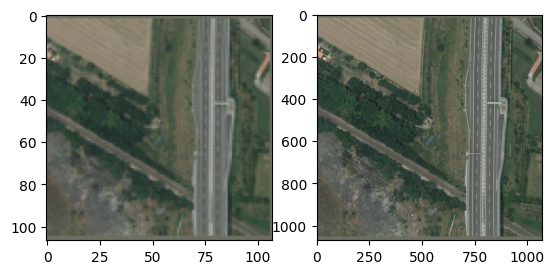

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image 1


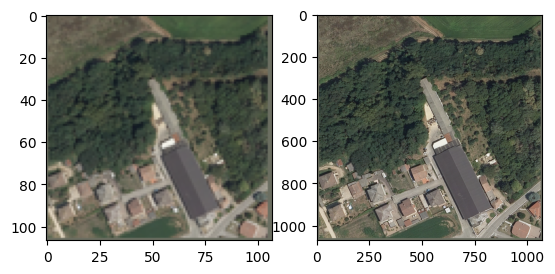

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image 2


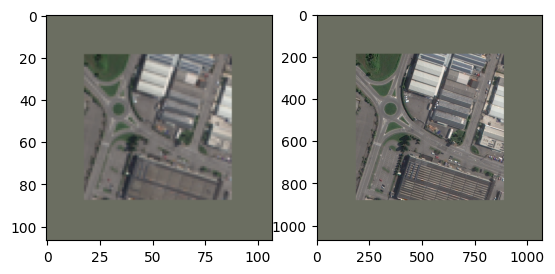

image 3


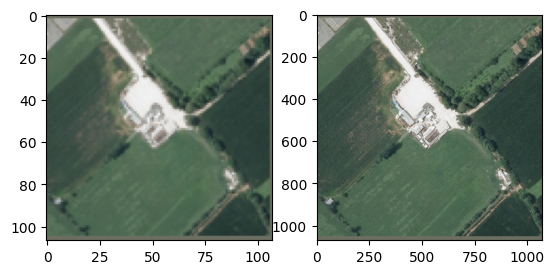

In [9]:
import matplotlib.pyplot as plt

for i in range(len(img)):
    print(f'image {i}')
    pic = tu.reverse_image_standardisation(img[i], rgb_means, rgb_stds)
    target_pic = tu.reverse_image_standardisation(target[i], rgb_means, rgb_stds) 
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(torch.permute(pic, (2,1,0))) 
    ax[1].imshow(torch.permute(target_pic, (2,1,0)))
    plt.show()                 

start by running tensorbord on CMD:
tensorboard --logdir=runs

then go to http://localhost:6006/

In [10]:
from torch.utils.tensorboard import SummaryWriter
import torchvision
import numpy as np

In [11]:
# writer = SummaryWriter('runs/1') 

In [12]:
# img_grid = torchvision.utils.make_grid(pic)
# writer.add_image('images', img_grid, 0)
# writer.add_graph(model, images)
# writer.close()

### Training on GPU/CPU

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Define training loop

In [14]:
# def compute_psnr(x, y, max_pixel=1):
#     x = x / float(max_pixel)
#     y = y / float(max_pixel)
#     mse = torch.mean((x - y) ** 2, dim=[1, 2, 3])
#     psnr_val = 20 * torch.log10(max_pixel/torch.sqrt(mse))
#     return psnr_val

### Define model, loss function, optimizer, num_epochs

In [15]:
# model = SimpleModel()
# model.to(device)
# loss_fn = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# num_epochs = 4


In [16]:
from src.trainer.trainer import train_loop

### Train network

In [17]:
train_config={
    'model': 'SimpleModel',
    'optimizer': 'adam',
    'loss': 'MSE',
    'metric_fn': 'psnr',
    'num_epochs': 4,
    'lr': 0.001
}

In [18]:
train_loop(train_config, train_dataloader, val_dataloader, device, rgb_means, rgb_stds)

[1/26] Epoch: 1, Train loss: 1.085
[2/26] Epoch: 1, Train loss: 0.447
[3/26] Epoch: 1, Train loss: 0.314
[4/26] Epoch: 1, Train loss: 0.195


TypeError: int() argument must be a string, a bytes-like object or a number, not 'PngImageFile'

### Save model

In [23]:
fld_path = 'models/trained_models'
model_name = 'model1'
model_file_path = os.path.join(fld_path, f'{model_name}.pth')
torch.save(model.state_dict(),model_file_path)
print(os.listdir(fld_path))

['model1.pth']


### Loading model

In [24]:
test_model = SimpleModel()
test_model.load_state_dict(torch.load(model_file_path))
test_model.to(device)

SimpleModel(
  (up): Upsample(scale_factor=10.0, mode=nearest)
  (conv): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
)

### Run inference

In [26]:
evaluate(test_dataloader, test_model, compute_psnr, device)

tensor(14.5339)